In [1]:
from models import DeepFourierFeatures, DeepFourierFeaturesNetwork, RFF_layer
from ITL_utils import deep_JSD, JSD_cov
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import repitl.kernel_utils as ku
import pandas as pd
import seaborn as sns
colors = sns.color_palette()

In [3]:
def JS_cauchy_closed_form(l1,l2,s1,s2):
    Djs = np.log2(2*np.sqrt((l1-l2)**2 + (s1+s2)**2)/(np.sqrt((l1-l2)**2+(s1+s2)**2) + 2*np.sqrt(s1*s2)))
    return Djs

def find_parameters(Djs):
    # assuming s1 = s2 = 1.0 and l1 = 0.0
    a = 2**Djs 
    l2 = np.sqrt(((2*a)**2)/(2-a)**2-4)
    return l2   

In [4]:
def sigma_rule_of_thumb(X,Y):
    XY = torch.cat((X,Y))
    numSamples = X.shape[0] # + Y.shape[0]
    dists = ku.squaredEuclideanDistance(XY, XY)
    sigma_init = torch.sqrt(torch.sum(dists) / ( ((numSamples*2)**2 - (numSamples*2)) * 2 ))
    return sigma_init

In [5]:
# Utils for neural estimation
import torch.nn as nn
import torch.nn.functional as F


class V(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        return x

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        return x
    


class Activation_g(nn.Module):
  def __init__(self,divergence="JSD"):
    super(Activation_g,self).__init__()
    self.divergence =divergence
  def forward(self,v):
    divergence = self.divergence
    if divergence == "KLD":
      return v
    elif divergence == "RKL":
      return -torch.exp(-v)
    elif divergence == "CHI":
      return v
    elif divergence == "SQH":
      return 1-torch.exp(-v)
    elif divergence == "JSD":
      return torch.log(torch.tensor(2.))-torch.log(1.0+torch.exp(-v))
    elif divergence == "GAN":
      return -torch.log(1.0+torch.exp(-v)) # log sigmoid

class Conjugate_f(nn.Module):
  def __init__(self,divergence="JSD"):
    super(Conjugate_f,self).__init__()
    self.divergence = divergence
  def forward(self,t):
    divergence= self.divergence
    if divergence == "KLD":
      return torch.exp(t-1)
    elif divergence == "RKL":
      return -1 -torch.log(-t)
    elif divergence == "CHI":
      return 0.25*t**2+t
    elif divergence == "SQH":
      return t/(torch.tensor(1.)-t)
    elif divergence == "JSD":
      return -torch.log(2.0-torch.exp(t))
    elif divergence == "GAN":
      return  -torch.log(1.0-torch.exp(t))
     

class VLOSS(nn.Module): # X following P
  def __init__(self,divergence="JSD"):
    super(VLOSS,self).__init__()
    self.activation = Activation_g(divergence)
  def forward(self,v):
    return torch.mean(self.activation(v))
  
class QLOSS(nn.Module): # Y following Q
  def __init__(self,divergence="JSD"):
    super(QLOSS,self).__init__()
    self.conjugate = Conjugate_f(divergence)
    self.activation = Activation_g(divergence)
  def forward(self,v):
    return torch.mean(-self.conjugate(self.activation(v)))


class JSDGAN(nn.Module):
  def __init__(self):
    super(JSDGAN,self).__init__()
  def forward(self,Dx):
    JSD = torch.mean(torch.log2(Dx)) + torch.mean(torch.log2(1-Dx)) - 2*torch.log2(torch.tensor(0.5))    
    return JSD



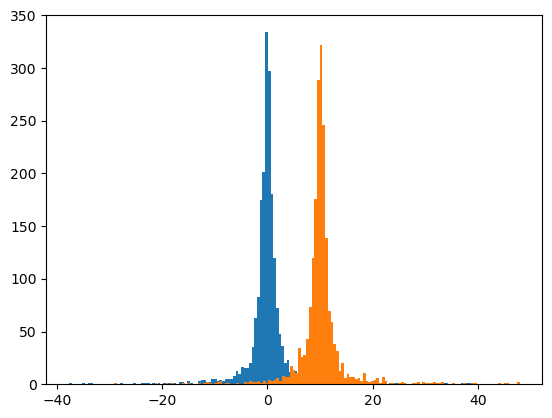

In [6]:
# Number of samples 
n = 2000
# Defining modes of the distributions
l1 = 0
l2 = 10
s1 =1.0
s2 = 1.0
p1 = stats.cauchy.rvs(loc=l1, scale=s1, size=n) 
p2 = stats.cauchy.rvs(loc=l2, scale=s2, size=n) 


p1_truncated = p1[(p1>l1-40) & (p1<l1+40)]  # truncate distribution so it plots well
p2_truncated = p2[(p2>l2-40) & (p2<l2+40)]  # truncate distribution so it plots well
plt.hist(p1_truncated,bins = 150)
plt.hist(p2_truncated,bins = 150)
plt.show()

In [7]:
def cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    estimator, 
    learning_rate,
    n_epochs,
    neural_estimator  = 'repJSD',
    update_covariance = False,
    EMA = False,
    alpha = 0.5, 
    is_cuda = False,
    figsize=(14, 3),
    legend = True, 
    title = None,
    bbox_to_anchor=(0.5,0.0)):

    # density parameters
    l1 = 0
    s1 =1.0
    s2 = 1.0
    # we'll find the location of the second distribution to achieved a desired value of divergence
    d_in = 1 # data dimensionality    
    steps = n_epochs*len(divergence_levels)
    D_true = np.zeros((steps,len(batch_sizes)))
    D_estimated = np.zeros((steps,len(batch_sizes)))

    if neural_estimator== 'NWJ':
        divergence = "JSD"
        Q_criterion =QLOSS(divergence)
        V_criterion =VLOSS(divergence)
    elif neural_estimator== 'JSDGAN':
        criterion = nn.BCELoss()
        
        
        

    fig, axs = plt.subplots(1,len(batch_sizes), figsize=figsize, facecolor='w', edgecolor='k')
    if len(batch_sizes) != 1:
        axs = axs.flatten()

    for bidx, batch_size in enumerate(batch_sizes):
        didx = 0
        i = 0
        if is_cuda:
            device = torch.device('cuda:0')   
        else:
            device = torch.device("cpu")
        
        if neural_estimator == 'NWJ':
            V_net = estimator.to(device)  
            V_net = V().to(device)
            optimizer  = torch.optim.Adam(list(V_net.parameters()) , lr = learning_rate)
        elif neural_estimator == 'JSDGAN':

            Discriminator = estimator.to(device)
            optimizer  = torch.optim.Adam(list(Discriminator.parameters()) , lr = learning_rate)
        else:      
            RFFestimator = estimator.to(device)
            optimizer  = torch.optim.Adam(list(estimator.parameters()) , lr = learning_rate)
        for didx, divergence_level  in enumerate(divergence_levels):       
            l2 = find_parameters(divergence_level)

            for epoch in range(n_epochs):
                X = stats.cauchy.rvs(loc=l1, scale=s1, size=batch_size) 
                Y = stats.cauchy.rvs(loc=l2, scale=s2, size=batch_size)
                X = torch.tensor(X,dtype = torch.float, device = device).view(-1,1)
                Y = torch.tensor(Y,dtype = torch.float, device = device).view(-1,1)
                if neural_estimator == "NWJ": 
                    Vx  = V_net(X)
                    Vy  = V_net(Y)
                    divergence = (V_criterion(Vx) + Q_criterion(Vy))
                    loss = -1*divergence
                elif neural_estimator == "JSDGAN":
                    # Adversarial ground truths

                    Dx = Discriminator(X)
                    Dy = Discriminator(Y)
                    Lx = torch.ones_like(X, requires_grad=False)
                    Ly = torch.zeros_like(Y, requires_grad=False)
                    loss  = criterion(Discriminator(X), Lx) + criterion(Discriminator(Y), Ly)
                    eps = 1e-10
                    if torch.mean(Dx) < 0.5:
                        divergence =   0.5*(torch.mean(torch.log2((1-Dx) +eps)) + torch.mean(torch.log2((Dy) + eps)) - 2*torch.log2(torch.tensor(0.5)))
                    else:
                        divergence =   0.5*(torch.mean(torch.log2((Dx) +eps)) + torch.mean(torch.log2((1-Dy) + eps)) - 2*torch.log2(torch.tensor(0.5)))
                    
                    
                    
                else:    
                    phiX = RFFestimator(X)
                    phiY = RFFestimator(Y)
                    covX = torch.matmul(torch.t(phiX),phiX)
                    covY = torch.matmul(torch.t(phiY),phiY)
                    if update_covariance:
                        if i%n_epochs == 0:
                            covX_ma = covX
                            covY_ma = covY
                        else:
                            if EMA:
                                covX_ma = (1-alpha)*covX_last + (alpha)*covX
                                covY_ma = (1-alpha)*covY_last + (alpha)*covY
                            else:
                                covX_ma = covX_last + covX
                                covY_ma = covY_last + covY
                    else:
                        covX_ma = covX
                        covY_ma = covY
                    
                    divergence = JSD_cov(covX_ma,covY_ma)
                    loss = -1*divergence
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step()
                
                D_estimated[i,bidx] = divergence.detach().cpu().item()
                D_true[i,bidx] = JS_cauchy_closed_form(l1,l2,s1,s2)
                if update_covariance: 
                    covX_last = covX_ma.detach().clone()
                    covY_last = covY_ma.detach().clone()
                i = i+1
        
        EMA_SPAN = n_epochs//10
        D_estimated_smooth = pd.Series(D_estimated[:,bidx]).ewm(span=EMA_SPAN).mean()

        if (title is None):
            title_ = f"N = {str(batch_size)}"
        else:
            title_ = title
        if len(batch_sizes) != 1:
            axs[bidx].plot(D_estimated[:,bidx], alpha=0.4, label = "Estimated divergence")
            axs[bidx].plot(D_estimated_smooth, color = colors[0])
            axs[bidx].plot(D_true[:,bidx], label = 'True divergence', color = 'black')
            axs[bidx].set_title(title_, fontsize = 20)
            axs[bidx].set_xlabel("epoch")
            axs[bidx].set_ylabel(r"$D_{JS}$")
            handles, labels = axs[bidx].get_legend_handles_labels()
        else:
            axs.plot(D_estimated[:,bidx], alpha=0.4, label = "Estimated divergence")
            axs.plot(D_estimated_smooth, color = colors[0])
            axs.plot(D_true[:,bidx], label = 'True divergence', color = 'black')
            axs.set_title(title_, fontsize = 20)
            axs.set_xlabel("epoch")
            axs.set_ylabel(r"$D_{JS}$")
            handles, labels = axs.get_legend_handles_labels()

    if legend:
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=bbox_to_anchor)

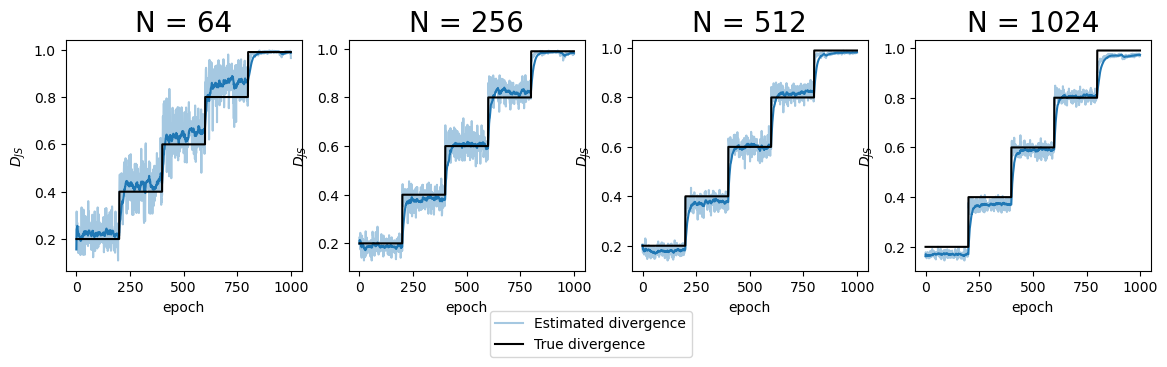

In [9]:
divergence_levels = [0.2,0.4,0.6,0.8,0.99]
batch_sizes =  [64,256,512,1024]
n_RFF = 50
learning_rate = 0.001
n_epochs = 200
n_RFF = 50 
sigma = torch.tensor(2.0)
d_in = 1
RFFestimator = RFF_layer(d_in, n_RFF,sigma,freezeRFF=False)
cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    RFFestimator, 
    learning_rate,
    n_epochs,
    update_covariance = False,
    is_cuda = False)

### EMA

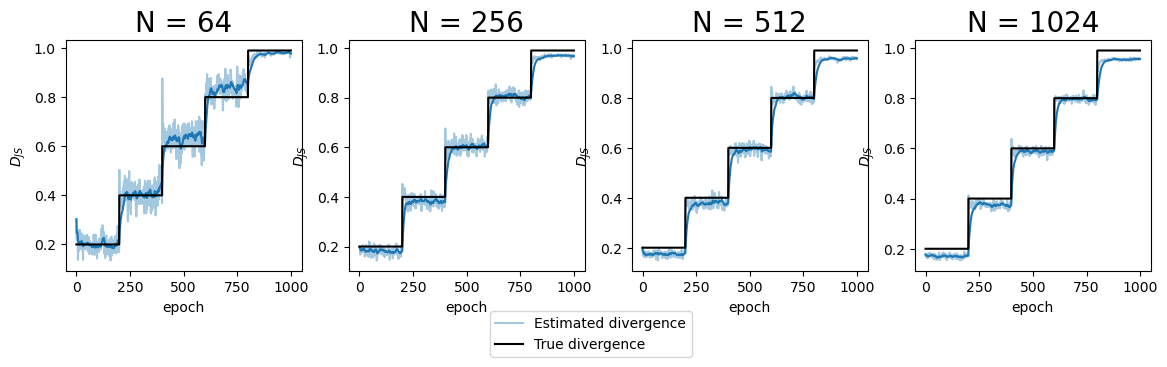

In [10]:
cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    RFFestimator, 
    learning_rate,
    n_epochs,
    update_covariance = True,
    EMA= True,
    alpha = 0.5,
    is_cuda = False)

## Deep Fourier Features Network (DFFN)

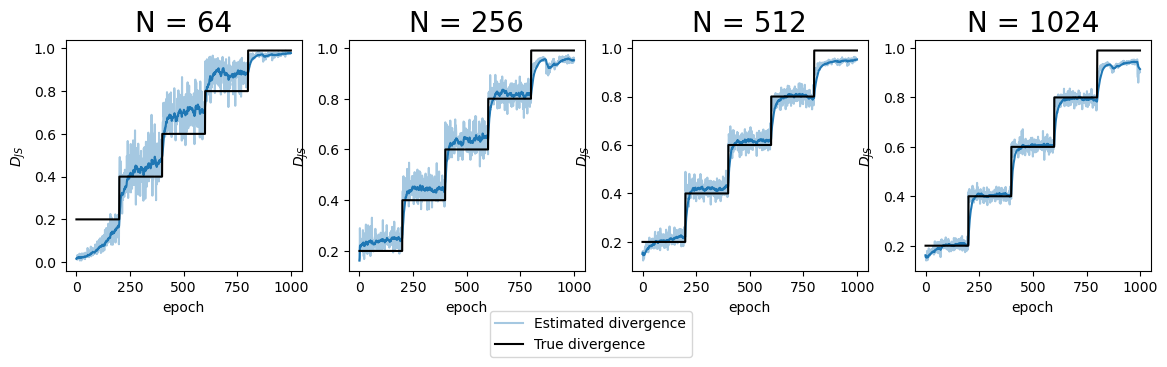

In [18]:
divergence_levels = [0.2,0.4,0.6,0.8,0.99]
batch_sizes =  [64,256,512,1024]
n_RFF = 50
learning_rate = 0.001
n_epochs = 200

H = 5
d_in = 1
sigma = torch.tensor(2.0)
estimator = DeepFourierFeaturesNetwork(d_in, H, H,n_RFF,sigma,freezeRFF=False)


cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    estimator, 
    learning_rate,
    n_epochs,
    update_covariance = False,
    EMA= False,
    is_cuda = True)

A very complex network can easility overfit and not estimate properly the divergence as well as very high learning rates. 

## Comparison with neural estimators of F-divergences

# Comparison between the estimators



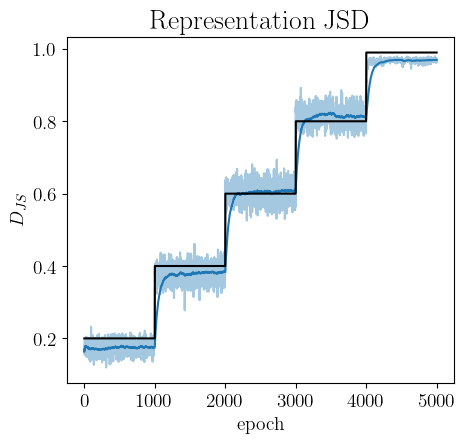

In [48]:
# import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('bmh')
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}


plt.rc('font', **font)

divergence_levels = [0.2,0.4,0.6,0.8,0.99]
batch_sizes =  [512,]
n_RFF = 50
learning_rate = 0.001
n_epochs = 1000
n_RFF = 50 
sigma = torch.tensor(2.0)
d_in = 1
RFFestimator = RFF_layer(d_in, n_RFF,sigma,freezeRFF=False)
cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    RFFestimator, 
    learning_rate,
    n_epochs,
    update_covariance = False,
    is_cuda = False,
    figsize= (5,4.5),bbox_to_anchor= (0.35,0.89), legend = False, title = "Representation JSD")

plt.savefig('./Figures/repJSDestimation.pdf', dpi=300, bbox_inches='tight')

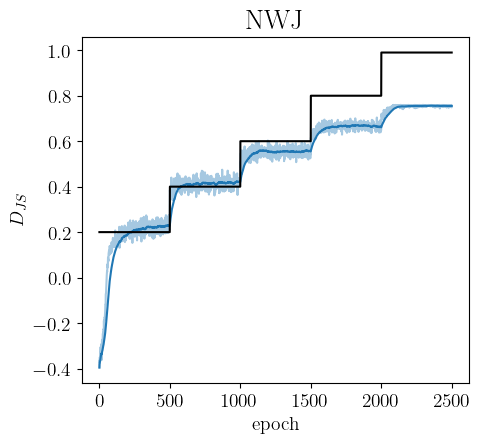

In [49]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}


plt.rc('font', **font)

divergence_levels = [0.2,0.4,0.6,0.8,0.99]
batch_sizes =  [512,]

learning_rate = 0.01
n_epochs = 500
discriminator = V()
cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    discriminator, 
    learning_rate,
    n_epochs,
    neural_estimator='NWJ',
    is_cuda = True,
    figsize= (5,4.5),bbox_to_anchor= (0.35,0.89), 
    legend = False, 
    title = "NWJ ")
plt.savefig('./Figures/NWJestimation.pdf', dpi=300, bbox_inches='tight')

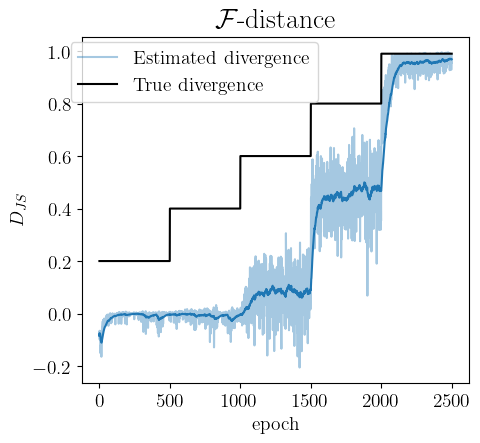

In [50]:
divergence_levels = [0.2,0.4,0.6,0.8,0.99]
batch_sizes =  [512,]
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}


plt.rc('font', **font)
learning_rate = 0.01
n_epochs = 500
discriminator = D()
cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    discriminator, 
    learning_rate,
    n_epochs,
    neural_estimator='JSDGAN',
    is_cuda = True,
    figsize= (5,4.5),bbox_to_anchor= (0.35,0.89), 
    legend = True, 
    title = r"$\mathcal{F}$-distance")
plt.savefig('./Figures/fdistance.pdf', dpi=300, bbox_inches='tight')

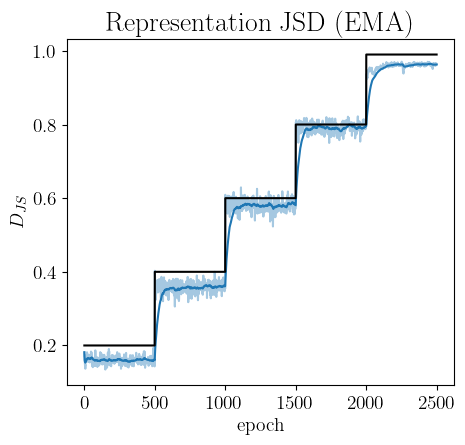

In [51]:
divergence_levels = [0.2,0.4,0.6,0.8,0.99]
batch_sizes =  [512,]
n_RFF = 50
learning_rate = 0.001
n_epochs = 500
n_RFF = 50 
sigma = torch.tensor(2.0)
d_in = 1
RFFestimator = RFF_layer(d_in, n_RFF,sigma,freezeRFF=False)
cauchy_densities_divergence_estimation(
    divergence_levels,
    batch_sizes,
    RFFestimator, 
    learning_rate,
    n_epochs,
    update_covariance = True,
    EMA=True,
    alpha = 0.5, 
    is_cuda = False,
    figsize= (5,4.5),bbox_to_anchor= (0.35,0.89), legend = False, title = "Representation JSD (EMA)")

plt.savefig('./Figures/repJSDupdatingestimation.pdf', dpi=300, bbox_inches='tight')